### Insights Follow-ups: Additional Analysis

Part 2:
- Histogram of total BW increase from 2015 to 2019 -- project to 4 years from now
- Did most have 4x?
- Over the last 4 years, cost of bw has performed such that you should be able to get x bw for same $$...we would project that x% of districts would be at 1Mb in 4 years
- How does this compare to Jamie’s price forecasting waterfall?

In [1]:
from __future__ import division

import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

sql_query = """
select 
    d.district_id,
    d.funding_year,
    d.district_type,
    d.in_universe,
    dffa.fit_for_ia,
    d.num_students,
    dbw.ia_bw_mbps_total,
    dbw.meeting_2018_goal_oversub

-- basic district info
FROM ps.districts d

-- district costs and bw
JOIN ps.districts_bw_cost dbw
ON d.district_id = dbw.district_id
AND d.funding_year = dbw.funding_year

-- to check for fit for ia
JOIN ps.districts_fit_for_analysis dffa
ON d.district_id = dffa.district_id
AND d.funding_year = dffa.funding_year

where d.funding_year in (2015, 2019)
and dffa.fit_for_ia = True
and d.district_type = 'Traditional'
and d.in_universe = True
"""

#query data
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [4]:
df.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,meeting_2018_goal_oversub
0,881421,2015,Traditional,True,True,5598,800,False
1,881421,2019,Traditional,True,True,5687,2000,False
2,881422,2015,Traditional,True,True,173,100,False
3,881422,2019,Traditional,True,True,194,1000,True
4,881423,2015,Traditional,True,True,1295,174,False


### Convert decimal to floats

In [5]:
numeric_cols = ['num_students', 'ia_bw_mbps_total']
df[numeric_cols] = df[numeric_cols].astype(float)

### Limiting to districts that are 'Traditional', in_universe, and are fit_for_ia in both 2015 and 2019 years `df_subset`

In [6]:
# count the rows for each districts (should be 1 or two)
df_temp = df.groupby('district_id')['funding_year'].count().to_frame()

# takes the district_ids that have 2 rows (these are districts that are fit for analysis for 2015 and 2019)
df_subset = df[df.district_id.isin(df_temp[df_temp.funding_year == 2].index)]

### X-fold, Percent Bandwidth Change from 2015 to 2019

In [7]:
# percent bandwidth change from 2015 to 2019
def calc_pct_diff(data):
    df_temp = data.set_index('funding_year')
    df_temp['diff_bw_total'] = df_temp.loc[2019]['ia_bw_mbps_total'] - df_temp.loc[2015]['ia_bw_mbps_total']
    return df_temp.reset_index(drop=True)

# adds difference between 2015 and 2019 bw
df_subset_v2 = df_subset.groupby('district_id').apply(calc_pct_diff)

# reset_index
df_subset_v2.reset_index(drop=True, inplace=True)

# calculate pct_bw_change
df_subset_v2['pct_bw_change_2015_to_2019'] = (df_subset_v2['diff_bw_total']/df_subset_v2['ia_bw_mbps_total'])*100

# only keep the first row for each district
df_first = df_subset_v2.groupby('district_id').first().reset_index()

# keeping only positive bw increase
df_first_positive_only = df_first[df_first.pct_bw_change_2015_to_2019 >= 0]

In [8]:
print(f"Number of districts with clean 2015 and 2019 data: {df_first.shape[0]}")
print(f"Number of districts with clean 2015 and 2019 data and removing any negative bw increase: {df_first_positive_only.district_id.nunique()}")

Number of districts with clean 2015 and 2019 data: 9900
Number of districts with clean 2015 and 2019 data and removing any negative bw increase: 9309


### Plotting the distribution of bw increases

In [10]:
# indicate bins for categories
max_bin = 3100
increment = 100
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_first_positive_only.loc[:,'bw_pct_change_category'] = pd.cut(df_first_positive_only['pct_bw_change_2015_to_2019'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_first_positive_only.loc[:, 'bw_pct_change_category'] = df_first_positive_only['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_first_positive_only[['bw_pct_change_category']] = df_first_positive_only[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_first_positive_only.loc[:, 'bw_pct_change_category'] = df_first_positive_only['bw_pct_change_category'].astype(str)

In [11]:
df_first_positive_only.head()

,district_id,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,meeting_2018_goal_oversub,diff_bw_total,pct_bw_change_2015_to_2019,bw_pct_change_category
0,881421,Traditional,True,True,5598.0,800.0,False,1200.0,150.000000,100%
1,881422,Traditional,True,True,173.0,100.0,False,900.0,900.000000,900%
2,881423,Traditional,True,True,1295.0,174.0,False,1826.0,1049.425287,1000%
3,881427,Traditional,True,True,13697.0,3000.0,False,7000.0,233.333333,200%
4,881431,Traditional,True,True,9299.0,980.0,False,6520.0,665.306122,600%


In [12]:
# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_first_positive_only.bw_pct_change_category.value_counts().to_frame()

# merge into resultant dataframe to keep order of index
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count']

# add percent of districts by category 
df_pct_change.loc[:, 'district_count_pct'] = df_pct_change['district_count']/df_pct_change.district_count.sum()

In [13]:
# reverse order for cumulative plot
df_pct_change_desc_ind = df_pct_change.sort_index(ascending=False)

### How many districts/percent of districts had at least 4x or more bandwidth in 2019 than in 2015?

In [14]:
# adding cumulative column
df_pct_change_desc_ind.loc[:, 'district_count_cumsum'] = df_pct_change_desc_ind['district_count'].cumsum(axis = 0)

# adding cumulative percent column
# percentage by pct_category - cumulative(sample)
df_pct_change_desc_ind.loc[:, 'district_count_cumsum_pct'] = df_pct_change_desc_ind.loc[:, 'district_count_cumsum']/df_pct_change_desc_ind.district_count.sum()

### Plotting by pct_category

In [15]:
df_pct_change

,pct_category,district_count,district_count_pct
0,less than 100%,2306,0.247717
1,100%,1636,0.175744
2,200%,644,0.069180
3,300%,615,0.066065
4,400%,874,0.093888
5,500%,366,0.039317
6,600%,118,0.012676
7,700%,143,0.015361
8,800%,115,0.012354
9,900%,1159,0.124503


In [16]:
df_pct_change.district_count.sum()

9309

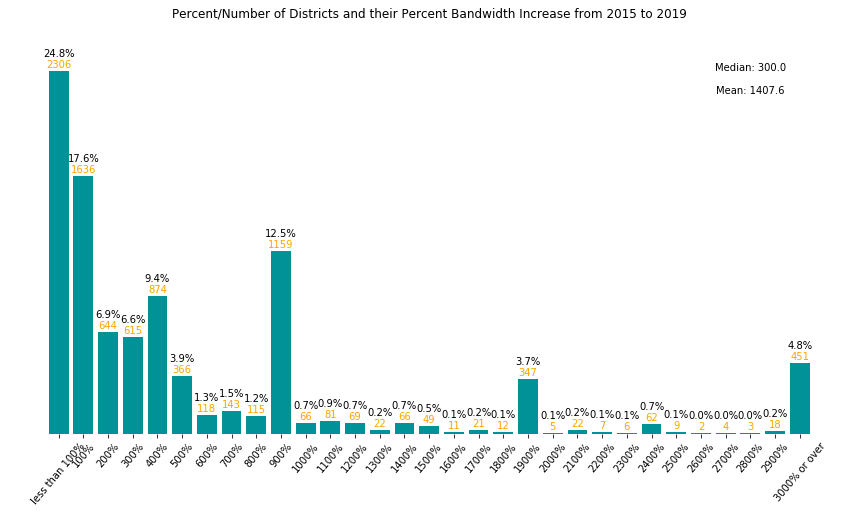

In [20]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['district_count'], color='#009296')

# ticks, titles, axis labels
# plt.ylabel("Percent/Number of Districts Percent Bandwidth Increase")
plt.title("Percent/Number of Districts and their Percent Bandwidth Increase from 2015 to 2019", y=1.08)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=50)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count'], 
                         df_pct_change['district_count'],
                         df_pct_change['district_count_pct']
                        ):
    plt.text(x0, v0+10, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+80, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(28, 2300, "Median: "+str(round(df_first_positive_only.pct_bw_change_2015_to_2019.median(), 1)), ha='center', va='bottom')
plt.text(28, 2150, "Mean: "+str(round(df_first_positive_only.pct_bw_change_2015_to_2019.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("hist_pct_bw_increase_2015_to_2019_by_pct_cat_073019.png", bbox_inches = 'tight')



### Plotting by pct_category - Cumulative

In [21]:
df_pct_change_desc_ind

,pct_category,district_count,district_count_pct,district_count_cumsum,district_count_cumsum_pct
30,3000% or over,451,0.048448,451,0.048448
29,2900%,18,0.001934,469,0.050381
28,2800%,3,0.000322,472,0.050704
27,2700%,4,0.000430,476,0.051133
26,2600%,2,0.000215,478,0.051348
25,2500%,9,0.000967,487,0.052315
24,2400%,62,0.006660,549,0.058975
23,2300%,6,0.000645,555,0.059620
22,2200%,7,0.000752,562,0.060372
21,2100%,22,0.002363,584,0.062735


In [22]:
# reverse order again for plotting
df_pct_change_desc_ind_plot = df_pct_change_desc_ind.sort_index()

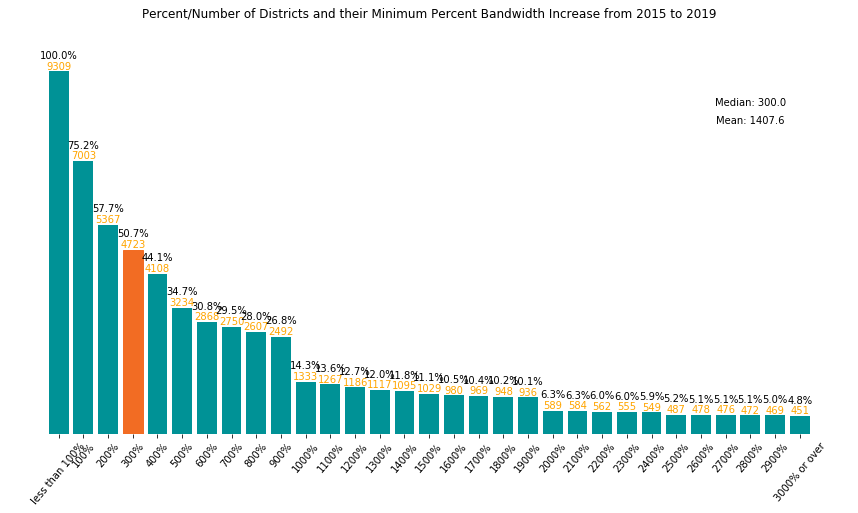

In [24]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change_desc_ind_plot.shape[0])
barlist=plt.bar(xmarks, df_pct_change_desc_ind_plot['district_count_cumsum'], color='#009296')
barlist[3].set_color('#f26c23')

# ticks, titles, axis labels
# plt.ylabel("Percent/Number of Districts Percent Bandwidth Increase")
plt.title("Percent/Number of Districts and their Minimum Percent Bandwidth Increase from 2015 to 2019", y=1.08)
plt.xticks(xmarks, df_pct_change_desc_ind_plot.pct_category.values, rotation=50)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change_desc_ind_plot['district_count_cumsum'], 
                         df_pct_change_desc_ind_plot['district_count_cumsum'],
                         df_pct_change_desc_ind_plot['district_count_cumsum_pct']):
    plt.text(x0, v0+5, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+280, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')

# additional text: median, mean
plt.text(28, df_pct_change_desc_ind_plot.district_count.sum()-df_pct_change_desc_ind_plot.district_count.sum()*.1, "Median: "+str(round(df_first_positive_only.pct_bw_change_2015_to_2019.median(), 1)), ha='center', va='bottom')
plt.text(28, df_pct_change_desc_ind_plot.district_count.sum()-df_pct_change_desc_ind_plot.district_count.sum()*.15, "Mean: "+str(round(df_first_positive_only.pct_bw_change_2015_to_2019.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("hist_pct_bw_increase_2015_to_2019_cumulative_073019.png", bbox_inches = 'tight')

### Of the 300% or more group (4723 districts), how many are Meeting 1 Mbps?

In [25]:
df_4x = df_first_positive_only[df_first_positive_only.pct_bw_change_2015_to_2019 >=300]
df_4x.shape

(4723, 10)

In [26]:
print(f"Number of Districts in '300% or over group': {df_4x.meeting_2018_goal_oversub.count()}")
print(f"Number of Districts in '300% or over group' and Meeting 1 Mbps Per Student: {df_4x.meeting_2018_goal_oversub.value_counts()[True]}")
print(f"Percent of 300% and over group that is Meeting 1 Mbps: {round((df_4x.meeting_2018_goal_oversub.value_counts()[True]/df_4x.meeting_2018_goal_oversub.count())*100, 2)}%")

Number of Districts in '300% or over group': 4723
Number of Districts in '300% or over group' and Meeting 1 Mbps Per Student: 91
Percent of 300% and over group that is Meeting 1 Mbps: 1.93%


In [1]:
# convert jupyter notebook to .py
!jupyter nbconvert --to script hist_bw_inc_pct_4x.ipynb

[NbConvertApp] Converting notebook hist_bw_inc_pct_4x.ipynb to script
[NbConvertApp] Writing 10259 bytes to hist_bw_inc_pct_4x.py
